# The ionization structure of the nebula.
Objectives: 
* to compute the ionization structure of nebulae, with a single hot star at the center.
* Adopt the Stromgren sphere approximation, spherical symmetry, one density, etc. 
* Produce plots of the ionized and neutral fractions { ne / nH, nH+ / nH } as function of radius R

In [1]:
#standard imports
import numpy as np
import scipy as sp
import scipy.integrate as integrate
import matplotlib.pyplot as plt 
import astropy.units as u
import astropy.constants as const

In [2]:
# Planck function.  in frequency, using units
def Bnu(nu, T): 
    """
        Expects nu in Hz and T in K using astropy.units
        Returns a luminosity density in erg/s/Hz 
    """
    prefactor = 2. * const.h / const.c**2 * nu**3 
    exprat    = const.h * nu / const.k_B / T
    exponent  = np.exp(exprat.to(u.dimensionless_unscaled).value - 1.) 
    B =  prefactor / exponent
    return B

# Exercise 1A
Write down the given parameters of the question and some physical constants

We use astropy.units for the moment to introduce this concenpt and make it more pedagogical.  

Later we will drop the units for speed of computation in Python

In [3]:
# Model parameters
T_star   = 4.e4     * u.Kelvin            # stellar temperature
L_star   = 4.e39    * u.erg/u.second      # luminosity of star
n_H      = 1.e4     * u.cm**-3            # number density of hyrdrogen.
T_gas    = 10000.   * u.Kelvin            # temperautre of the gas
alpha_B  = 2.59e-13 * u.cm**3 / u.second  # Case B recombination coefficient assuming T=10^4 
sigma_H0 = 6.3e-18  * u.cm**2             # cross section, simga_0 at Lyman edge.

### First objective: calculate the number of ionizing photons produced. 
We do this by integrating the Planck function (above) finding the correct normalization.

Then integrate at energies above the ionization edge so that we get back the total number of ionizing photons 

In photoionization equilibrium ,this is simply the photoionization rate. 

In [4]:
lam = np.linspace(10,50000,10000) * u.Angstrom  # wavelength vector (convenience of thinking in lambda)
nu  = const.c / lam                             # frequency
Lnu = Bnu(nu, T_star)                           # Luminosity density L_nu, i.e. per unit frequency. 

# Note Lnu is just the shape, not normalized to the total stellar luminosity. 
# This is given by the question in Cell 3 above as L_star

# To do this part elegantly, we need to properly equate Planck's fn with the the Boltzmann law,
#   and place the normalization constant as L* multipled by some fn of T and sigma_SB. 
# Since the question admits the solution should end up being numerical, we omit this
#   and state Lstar = CONSTANT * Int Bnu() d.nu  
# Kevin Krisciunas has written a whole paper on integrating the Placnk function.
#   https://people.physics.tamu.edu/krisciunas/planck.pdf

C1 = L_star / np.trapz(Lnu,-nu)     # C1 now gives constant of integration accounting for stellar luminosity
                                    # - sign because 'convenience' above means frequency decreasing

# relevant ionizing frequencies.   Integrate from ionization edge at 1 Rydberg (13.6 eV) to 10x this.
E_0   = 13.6 * u.eV
E_max = 10 * E_0
nuion = ( np.linspace (E_0, E_max, 1000) / const.h).to(u.Hz)    # frequency vector, ionizing radiation only
Q_0 = (C1 * np.trapz(Bnu(nuion, T_star) / (const.h*nuion), nuion)).to(u.second**-1)  
print ('Ionizing photon production rate, Q_0:',Q_0)   

# Answer should be ~6e49 s^-1

Ionizing photon production rate, Q_0: 5.943855237984121e+49 1 / s


### Second objective: estimate the average photoionization cross section.
estimate the average, effective energy of the ionizing photons.  

Use integrals for the weighted average. 

Look up cross section from there.


In [5]:
### take a weighted integral: 
# I.e.    Int( sigma(E) * E dE )
#         ---------------------
#              Int(E dE)
sigma_H    = sigma_H0*(nuion/nuion[0])**-3   # cross sections for our ionizing frequencies

sigma_Heff = (np.trapz(Bnu(nuion, T_star) * sigma_H / (const.h*nuion), nuion) /
             (np.trapz(Bnu(nuion, T_star)           / (const.h*nuion), nuion)))
print  ('sigma_effective:', sigma_Heff)    

# answer is ~3e-18 cm^2, compared to 6.3e-18 cm^2 at the ionization edge.

sigma_effective: 3.1733224386883947e-18 cm2


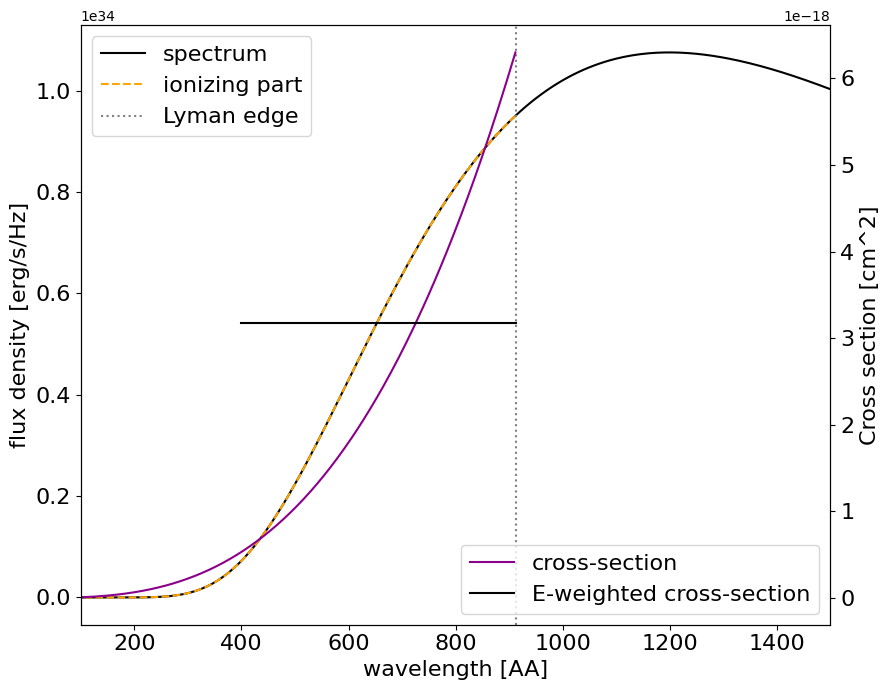

In [6]:
f, a = plt.subplots(tight_layout=True, figsize=(9,7))
a.plot(lam, C1 * Bnu(nu, T_star), 'k-', label='spectrum')
a.plot((const.c/nuion).to(u.Angstrom), C1*Bnu(nuion, T_star)/1e30, label='ionizing part',  c='orange', ls='--')
a.axvline(912, c='gray', ls=':', label='Lyman edge')
a.set_xlim(100,1500)
a.legend(fontsize=16, loc=2)

a.set_xlabel('wavelength [AA]',fontsize=16)
a.set_ylabel('flux density [erg/s/Hz]',fontsize=16)
a.tick_params(axis='both', which='major', labelsize=16)


#a.plot((const.c/nuion).to(u.Angstrom), sigma_H*1e51, label='cross-section * 1e51')
#a.plot([400,912], 2*[sigma_Heff.cgs.value*1e51], c='k', ls='-', label='E-weighted cross-section * 1e51')
at = plt.twinx()
at.plot((const.c/nuion).to(u.Angstrom), sigma_H, c='darkmagenta', label='cross-section')
at.plot([400,912], 2*[sigma_Heff.cgs.value], c='k', ls='-', label='E-weighted cross-section')
at.legend(fontsize=16, loc=4)
at.set_ylabel('Cross section [cm^2]', fontsize=16)
at.tick_params(axis='both', which='major', labelsize=16)

## Characteristics of the above plot. 
* Black shows the simple blackbody curve.  
* the dashed orange line shows the ionizing component of the BB curve. 

Both the above are shown on the left y-axis

* Magenta shows the photoelectric absorption cross section of the H atom.  This peaks at 6.3e-18 cm$^3$, and is shown using the right y-axis.  This part of the figure just mirrors Figure 13.1 and equation 13.3 of the Draine textbook. 

## Calculate the approximate Stromgren radius and mfp analytically. 

This will guide our expectations for the numerical calculation, and inform our decisions about which radius to use to start, step, and stop the calculation.  


In [7]:
R_S0  = (3./4./np.pi * Q_0 / n_H**2 / alpha_B)**(1./3.)
mfp = 1./n_H/sigma_Heff
print ('MFP [pc]=', mfp.to(u.pc))               # 1e-5 pc
print ('Stromgren radius [pc]=', R_S0.to(u.pc)) # 0.26 pc
print ('ratio of the two=', mfp/R_S0)           # few e-5

MFP [pc]= 1.0212574839334172e-05 pc
Stromgren radius [pc]= 0.26518120406599444 pc
ratio of the two= 3.851168439823742e-05


Reasons for the above numbers: 

* we must run the calculation to at least R_S0
* the stepsize must be less than 1x MFP, otherwise we will not see the effects near the Stromgren radius. 

# Now we have guidance, we can actually do the numerical calculation

In [8]:
# set up the integration
# remove astropy units for speed
rmin  = 0                        # minimum radius, start at zero but DON'T USE IT!
rmax  = R_S0.cgs.value * 1.3     # safely many MFPs beyond the ionization boundary
dr    = mfp.cgs.value / 2        # make sure we resolve the MFP with a few cells. 5x oversample this.
rvec  = np.arange(rmin, rmax, dr) # make an array from the above
#rvec  = np.linspace(rmin, rmax, 100000) # make an array from the above
print ('Radius.  Inner, outer, step [cm]', rmin, rmax, dr)

yvec  = rvec / R_S0.cgs.value    # work in normalized units.  y = r / Rstromgren
dy    = dr   / R_S0.cgs.value
print ('Normalized radius.  Inner, outer, step [R_S0]', yvec[0], yvec[-1], dy)

tau_S0 = n_H * sigma_Heff * R_S0  # total optical depth to R_S0, assuming pure HI
print ('tau_S0=', tau_S0)

Nstep = len(rvec)
print ('number of steps=', Nstep)

Radius.  Inner, outer, step [cm] 0 1.0637428053451245e+18 15756356615518.127
Normalized radius.  Inner, outer, step [R_S0] 0.0 1.299981162704703 1.925584219911871e-05
tau_S0= 25966.145486115573
number of steps= 67512


## Setting up the formulae

We begin by writing the recombination rate per unit volume, as always: 

$n_e n_p \alpha_B = n_H^2 x^2 \alpha_B$ if $n_H$ is the total number density of H and x is the ionized fraction. 

The above has to be equal to the photoionization rate, which must be $n_{H0} \sigma_{pi} \gamma$, where $\gamma$ is the photon flux crossing surface at distance r.  If Q(r) is the total rate of photons crossing radius r, then $\gamma$ must be $Q(r)/4\pi r^2$, and since $n_{H0}=n_H(1-x)$, then we can make these substitutions.  Setting the photoionization rate equal to the recombination rate then gives: 

$n_H^2 x^2 \alpha_B = \frac{Q(r)}{4\pi r^2}n_H(1-x) \sigma_{pi}$, which is eq. 15.10 of Draine. 

Here the inverse square law describes the geometric dilution of the photon flux with increasing radius (I.e. the conventional relationship between luminosity and flux).  What is missing, is some of the initial photon production $Q_0$ is absorbed on the way to r, in order to maintain the ioniztion state of the nebula.  With no gas, $Q(r) = Q(0) = Q_0$, but the rate at which photons reach radius r is reduced by the total photoionization rate (=recombination rate) inside r.  This is just the volume $\times n_e^2 \alpha_B$, such that:

$Q(r) = Q(0) - \frac{4\pi r^3}{3} n_H^2 x^2 \alpha_B$

We later arrive at equation 15.16: 

$\frac{x^2}{1-x} = \frac{1-y^3}{3y^2} \tau_{S0}$

In this, x is the ionized fraction $(n_{H+} / n_H)$, and y is the radius in units of the Stromgren radius, $r/R_{S0}$

In [9]:
x        = 1.   # ionized fraction. starting value assumes fully ionized
integral = 0.   # initialize integral to 0
tau      = 0.   # starting optical depth is 0
xvec     = np.zeros(len(rvec), dtype=np.float64)
tvec     = np.zeros(len(rvec), dtype=np.float64)

# Loop over all radii.  Ignore the 0 in the first radius to prevent /0 when solving for x
for iy in range(1,Nstep):   
    integral += x**2  *  yvec[iy]**2 * (yvec[iy]-yvec[iy-1])  # exactly equation 15.9
    A         = tau_S0 / 3 / yvec[iy]**2 * (1 - 3*integral)   # 15.11 using 
    x         = -A/2 + np.sqrt( (A/2)**2 + A)                 
    tau      += sigma_Heff.cgs.value * n_H.cgs.value  * (1-x) * dr
    if (iy%10000)==0: 
        print ('y=', yvec[iy], 'r=', rvec[iy], 'int=', integral, 'A=',A,'x=',x, 'tau=',tau)
    xvec[iy]  = x
    tvec[iy]  = tau

y= 0.1925584219911871 r= 1.5756356615518128e+17 int= 0.0023802863125233996 A= 231765.52399826644 x= 0.999995685328031 tau= 0.007168113501393236
y= 0.3851168439823742 r= 3.1512713231036256e+17 int= 0.019040554702994976 A= 55024.59577260766 x= 0.9999818269716343 tau= 0.05881981254424318
y= 0.5776752659735612 r= 4.726906984655438e+17 int= 0.06425824596212282 A= 20936.950684577416 x= 0.9999522421148868 tau= 0.2141555993075599
y= 0.7702336879647484 r= 6.302542646207251e+17 int= 0.1523039915906881 A= 7923.397409717619 x= 0.9998738233603035 tau= 0.6104954057848317
y= 0.9627921099559354 r= 7.878178307759063e+17 int= 0.29738298685180514 A= 1007.0372175406153 x= 0.9990089553043617 tau= 2.22719700840085
y= 1.1553505319471224 r= 9.453813969310876e+17 int= 0.3333333333333333 A= 0.0 x= 0.0 tau= 4026.315825754667


In [10]:
# write to an output file because we need this numerical data for the next question. 
fh = open('Q1A_star.txt', 'w')
s  = '{:1.9g}  {:1.9g}  {:1.9g}  {:1.9g}\n' 
fh.write('#R[cm]          y[R_S0]         x        tau\n')
for iy in range(Nstep):
    fh.write(s.format(rvec[iy], yvec[iy], xvec[iy], tvec[iy]) )
fh.close()

/tmp/ipykernel_177880/1208759155.py:3: RuntimeWarning: divide by zero encountered in log10
  a1.plot(rvec, np.log10(xvec), label='n(H+)/n(H)') ;
/tmp/ipykernel_177880/1208759155.py:4: RuntimeWarning: divide by zero encountered in log10
  a1.plot(rvec, np.log10(1-xvec), label='n(H0)/n(H)');
/tmp/ipykernel_177880/1208759155.py:4: RuntimeWarning: invalid value encountered in log10
  a1.plot(rvec, np.log10(1-xvec), label='n(H0)/n(H)');
/tmp/ipykernel_177880/1208759155.py:5: RuntimeWarning: divide by zero encountered in log10
  a2.plot(rvec, np.log10(tvec), label='tau')


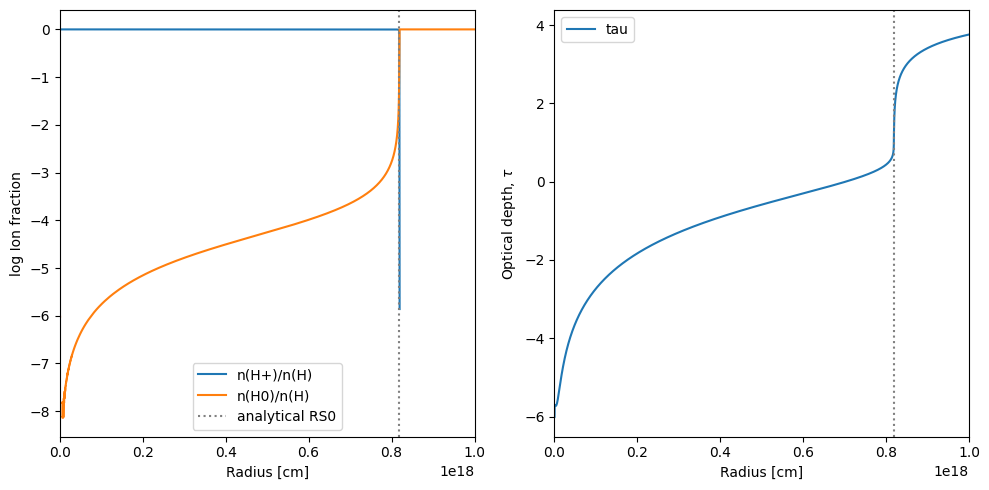

In [11]:
# plot 
f,[a1,a2]=plt.subplots(1,2, figsize=(10,5), tight_layout=True)
a1.plot(rvec, np.log10(xvec), label='n(H+)/n(H)') ;
a1.plot(rvec, np.log10(1-xvec), label='n(H0)/n(H)');
a2.plot(rvec, np.log10(tvec), label='tau')
a1.axvline(R_S0.cgs.value, c='grey', ls=':', label='analytical RS0')
a2.axvline(R_S0.cgs.value, c='grey', ls=':')
a1.set_xlim([0,1.e18])
#a1.set_ylim([-9,-6])
a2.set_xlim([0,1.e18])
a1.legend()
a2.legend()
#a1.set_xlim([R_S0.cgs.value*0.90,R_S0.cgs.value*1.05 ])
a1.set_xlabel(r'Radius [cm]')
a2.set_xlabel(r'Radius [cm]')
a1.set_ylabel(r'log Ion fraction')
a2.set_ylabel(r'Optical depth, $\tau$'); 

## Characteristics of the above plot. 
* Blue curve (left) shows the gas is fully ioinized (ion fraction ~1) inside the Stromgren radius, and fully neutral (ion fraction ~1e-6) outside. 
* Oragne curve (left) shows the residual neutlal fraction of HI in the HII region (1 - blue curve).  This always small.  This is set by the ratios of photoionization to recombination timescales. 
* The orange curve  is extremely low close to the star but grows with R for two reasons: (1.) the geometric dilution of photons, which follows the inverse square law, and (2.) the increase in optical depth tau which is the integral of of the residual fraction up to radius R.  
* This optical depth is shown in the right hand panel. 
* The transition between ionized and neutral gas is extremely sharp, and is associated with transtions in optical depth around 1.  The thickness of this transition region is a few mean-free-paths of ionizing radiation in atomic gas. (= a few optical depths)

# Exercise 1B 
now we will simply replace the stellar (blackbody) spectrum with that of an AGN (power-law)

4.1638635209818396e+52 1 / s


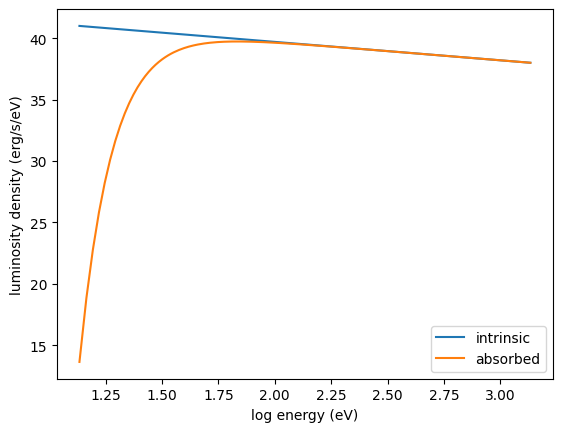

In [12]:
alpha = 1.5
evec  = np.arange(13.6, 1360, 1) * u.eV   # going to 100 eV -- start with overkill
lum_e = 1.e41 * (evec/evec[0])**-alpha * u.erg/u.second/u.eV

sigma_H = sigma_H0 * (evec/(13.6*u.eV))**-3

plt.figure()
plt.plot(np.log10(evec/u.eV), np.log10(lum_e.value), label='intrinsic')
plt.plot(np.log10(evec/u.eV), np.log10((lum_e*np.exp(-sigma_H * 1e19*u.cm**-2)).value), label='absorbed' )
# absorb with gas optically thick at 13.6eV
plt.xlabel('log energy (eV)')
plt.ylabel('luminosity density (erg/s/eV)')
plt.legend()

#print (np.exp(-sigma_H * 1e19*u.cm**-2) )

Q_0 = np.trapz(lum_e/evec, evec)
print(Q_0 .to(u.second**-1))    # ~1000x as ionizing as the star

In [13]:
# second job is to get the effective energy of these ionizing photons, and the appropriate cross section. 
# take a weighted integral. 
# I.e.    Int( sigma(E) * E dE )
#         ---------------------
#              Int(E dE)
sigma_H    = sigma_H0*(evec/evec[0])**-3   # cross sections for our ionizing frequencies

sigma_Heff = (np.trapz(Bnu(evec/const.h, T_star) * sigma_H , evec) /
             (np.trapz(Bnu(evec/const.h, T_star)           , evec)))
print  ('sigma_effective:', sigma_Heff)    # if it's not ~3e-18 cm2, it's not right. 

sigma_effective: 2.8257064426129836e-18 cm2


In [14]:
# Calculate the approximate Stromgren radius and mfp to guide our expectations. 
R_S0  = (3./4./np.pi * Q_0 / n_H**2 / alpha_B)**(1./3.)
mfp = 1./n_H/sigma_Heff
print ('MFP=', mfp.to(u.pc))               # 1e-5 pc
print ('Stromgren radius=', R_S0.to(u.pc)) # 0.26 pc
print ('ratio of the two=', (mfp/R_S0).to(u.dimensionless_unscaled))      # few e-5

MFP= 1.1468917084138279e-05 pc
Stromgren radius= 2.3551513723389244 pc
ratio of the two= 4.869715475123956e-06


In [15]:
# set up the actual integration. 
# remove astropy units for speed
rmin  = 0                        # minimum radius, start at zero but DON'T USE IT!
rmax  = R_S0.cgs.value * 1.3     # arbitrarily initialize to 1.5 Rstrom
dr    = mfp.cgs.value / 5       # make sure we resolve the MFP
rvec  = np.arange(rmin, rmax, dr) # make hte array
print ('Radius.  Inner, outer, step [cm]', rmin, rmax, dr)

yvec  = rvec / R_S0.cgs.value
dy    = dr   / R_S0.cgs.value
print ('Normalized radius.  Inner, outer, step [R_S0]', yvec[0], yvec[-1], dy)

tau_S0 = n_H * sigma_Heff * R_S0  # total optical depth to R_S0, assuming pure HI
print ('tau_S0=', tau_S0)

Nstep = len(rvec)
print ('number of steps=', Nstep)

Radius.  Inner, outer, step [cm] 0 9.447409127838298e+18 7077876066101.766
Normalized radius.  Inner, outer, step [R_S0] 0.0 1.2999997643771908 9.739430950247912e-07
tau_S0= 24.02886241107188 erg(1/3) / eV(1/3)
number of steps= 1334781


In [16]:
x        = 1.   # ionized fraction. starting value assumes fully ionized
integral = 0.   # initialize integral to 0
tau      = 0.   # starting optical depth is 0
xvec     = np.zeros(len(rvec), dtype=np.float64)
tvec     = np.zeros(len(rvec), dtype=np.float64)

# Loop over all radii.  Ignore the 0 in the first radius to prevent /0 when solving for x
for iy in range(1,Nstep):   
    integral += x**2  *  yvec[iy]**2 * dy
    A         = tau_S0 / 3 / yvec[iy]**2 * (1 - 3*integral)  
    x         = -A/2 + np.sqrt( (A/2)**2 + A)
    tau      += sigma_Heff.cgs.value * n_H.cgs.value  * (1-x) * dr
    #print ('y=', yvec[iy], 'r=', rvec[iy], 'int=', integral, 'A=',A,'x=',x, 'tau=',tau)
    xvec[iy]  = x
    tvec[iy]  = tau

In [17]:
fh = open('Q1B_AGN.txt', 'w')
s  = '{:1.9g}  {:1.9g}  {:1.9g}  {:1.9g}\n' 
fh.write('#R[cm]          y[R_S0]         x        tau\n')
for iy in range(Nstep):
    fh.write(s.format(rvec[iy], yvec[iy], xvec[iy], tvec[iy]) )
fh.close()

/tmp/ipykernel_177880/1383002687.py:2: RuntimeWarning: divide by zero encountered in log10
  a1.plot(rvec, np.log10(xvec), label='n(H+)/n(H)')
/tmp/ipykernel_177880/1383002687.py:3: RuntimeWarning: invalid value encountered in log10
  a1.plot(rvec, np.log10(1-xvec), label='n(H0)/n(H)')
/tmp/ipykernel_177880/1383002687.py:4: RuntimeWarning: divide by zero encountered in log10
  a2.plot(rvec, np.log10(tvec), label='tau')


Text(0, 0.5, 'optical depth tau')

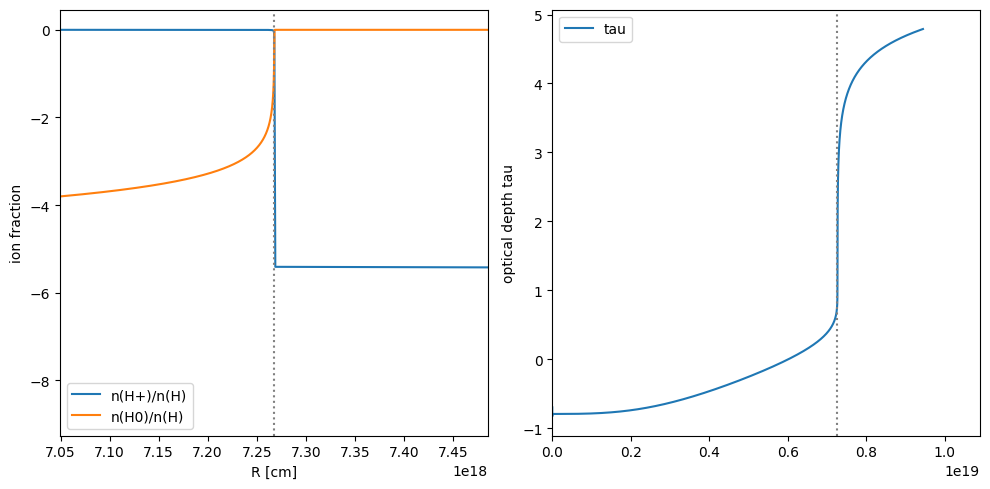

In [18]:
f,[a1,a2]=plt.subplots(1,2, figsize=(10,5), tight_layout=True)
a1.plot(rvec, np.log10(xvec), label='n(H+)/n(H)') 
a1.plot(rvec, np.log10(1-xvec), label='n(H0)/n(H)')
a2.plot(rvec, np.log10(tvec), label='tau')
a1.axvline(R_S0.cgs.value, c='grey', ls=':')
a2.axvline(R_S0.cgs.value, c='grey', ls=':')
a1.set_xlim([0,1.e18])
a2.set_xlim([0,1.e18])
a1.legend()
a2.legend()
a1.set_xlim([R_S0.cgs.value*0.97,R_S0.cgs.value*1.03 ])
a2.set_xlim([0,R_S0.cgs.value*1.5 ])
a1.set_xlabel('R [cm]')
a1.set_ylabel('ion fraction')
a2.set_ylabel('optical depth tau')